# FX

This notebook illustrates some basic aspects of FX markets, for instance, definition of currency returns and the idea of UIP.

## Load Packages and Extra Functions

In [1]:
using Dates

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Exchange Rate Quotations: Cross-Rates

In [3]:
CHF_USD = 0.9970                       #how many CHF to pay for 1 USD
USD_AUD = 0.8139

CHF_AUD = CHF_USD*USD_AUD

printlnPs("A cross rate: if CHF/USD=$CHF_USD and USD/AUD $USD_AUD, then CHF/AUD ≈",CHF_AUD)

A cross rate: if CHF/USD=0.997 and USD/AUD 0.8139, then CHF/AUD ≈     0.811


# Currency Returns

The strategy is: in $t=0$, you buy foreign currency (at the price $S_0$) and lend on foreign money market (at the safe rate $R_f^*$). Finally, in $t=1$ sell the foreign currency (at the price $S_1$). 

Since the strategy is financed by borrowing on the domestic money market (at the rate $R_f$), we express the excess return as 

$
R^e = (1+R_f^*)S_1/S_0 - (1 + R_f)
$

Notice that $R_f$ and $R_f^*$  are the safe rates over the investment period (for instance, one-month period). Conversion from annualized interest rates to these monthly rates is discussed under UIP (below).

In [4]:
S₀ = 1.2            #current spot FX rate, t=0
S₁ = 1.25           #spot FX rate in t=1
Rfstar = 0.06      #safe rate (foreign) between period 0 and 1
Rf     = 0.04      #safe domestic rate

Re = (1+Rfstar)*S₁/S₀ - (1 + Rf)

printblue("A simple example of how to calculate the excess return from investing in a foreign currency:")
xx = [S₀,Rf,Rfstar,S₁,Re]
printTable(xx,[" "],["S₀";"Rf";"Rfstar";"S₁";"Currency excess return"])

A simple example of how to calculate the excess return from investing in a foreign currency:
                                
S₀                         1.200
Rf                         0.040
Rfstar                     0.060
S₁                         1.250
Currency excess return     0.064



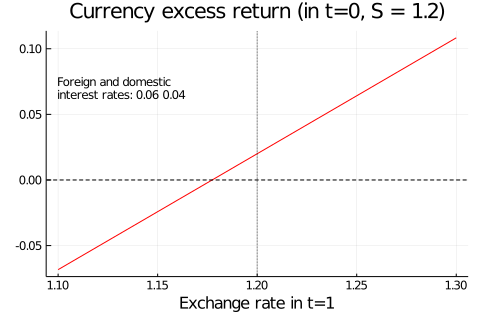

In [5]:
S₁ = 1.1:0.01:1.3           #vector, different possible exchange rates in t=1

Re = (1+Rfstar)*S₁/S₀ .- (1 + Rf)

p1 = plot( S₁,Re,
           legend = nothing,
           linecolor = :red,
           title = "Currency excess return (in t=0, S = $S₀)",
           xlabel = "Exchange rate in t=1",
           annotation = (1.1,0.07,text("Foreign and domestic \ninterest rates: $Rfstar $Rf",8,:left)) )
vline!([S₀],linecolor=:black,line=(:dot,1))
hline!([0],linecolor=:black,line=(:dash,1))
display(p1)

# Uncovered Interest Rate Parity (UIP)


UIP assumes that the expected future exchange rate ($\text{E}_0S_m$) is related to the current (as of $t=0$) exchange rate and interest rates in such a way that the expected excess return on a a foreign investment (on the foreign money market) is zero (set $R^e=0$ in the previous expression).

Interest rates are typically annualized (denoted $y$ and $y^*$ below). This means that the safe rate over an investment period of $m$ years (eg. $m=1/12$ for a month) is $(1+y)^m$.

In [6]:
S₀     = 1.2                      #current spot FX rate
y     = 0.04                      #annualized interest rates
ystar = 0.06
m     = 1/2                       #investment period
ESm   = S₀ * (1+y)^m/(1+ystar)^m  #implies E(excess return) = 0

printblue("Expected future exchange rate $m years ahead according to UIP:")
xx = [S₀,y,ystar,m,ESm]
printTable(xx,[" "],["S₀";"y";"ystar";"m";"UIP expectation of Sₘ"])

Expected future exchange rate 0.5 years ahead according to UIP:
                               
S₀                        1.200
y                         0.040
ystar                     0.060
m                         0.500
UIP expectation of Sₘ     1.189

